In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Part1: Data Cleaning

In [3]:
# Step 1: Load all raw data
precip_path = "precipitation-annual-tre.csv"
correct_temp_path = "average-mean-surface-air.csv"
oni_path = "Monthly Oceanic Nino Index (ONI) - Wide.csv"
copper_price_path = "Daily Copper Price.xlsx"

In [4]:
# Step 2: Clean precipitation data
def read_and_clean_climate_data(file_path, value_name):
    raw = pd.read_csv(file_path, sep=';', header=None)
    df = raw.copy().iloc[1:]
    df.columns = ['Year', 'CodeValue']
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Value'] = df['CodeValue'].astype(str).str.split(',').str[-1]
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df = df[['Year', 'Value']].dropna()
    df = df.rename(columns={'Value': value_name})
    return df

In [5]:
correct_precip_df = pd.read_csv("precipitation-annual-tre.csv")
precip_clean = correct_precip_df[['Year', 'Annual Precipitation']].rename(
    columns={'Annual Precipitation': 'Precipitation'}
).dropna()

In [6]:
correct_precip_df

,Year,Annual Precipitation,Trend 1951-2020,Trend 1971-2020,Trend 1991-2020
0,1950,1599.28,NaN,NaN,NaN
1,1951,1620.59,1451.140487,NaN,NaN
2,1952,1308.84,1452.423359,NaN,NaN
3,1953,1626.74,1453.706231,NaN,NaN
4,1954,1660.37,1454.989103,NaN,NaN
...,...,...,...,...,...
69,2019,1451.85,1538.375784,1520.840746,1520.718194
70,2020,1486.43,1539.658656,1520.932165,1521.175591
71,2021,1297.33,NaN,NaN,NaN
72,2022,1414.47,NaN,NaN,NaN


In [7]:
# Step 3: Clean copper price (daily to annual)
copper_df = pd.read_excel(copper_price_path)
date_col = copper_df['Date']
is_numeric = pd.to_numeric(date_col, errors='coerce').notnull()

copper_df['Parsed_Date'] = pd.NaT
copper_df.loc[is_numeric, 'Parsed_Date'] = pd.to_datetime(
    copper_df.loc[is_numeric, 'Date'].astype(float), origin='1899-12-30', unit='D')
copper_df.loc[~is_numeric, 'Parsed_Date'] = pd.to_datetime(
    copper_df.loc[~is_numeric, 'Date'], errors='coerce')

copper_df['Year'] = copper_df['Parsed_Date'].dt.year
annual_copper = copper_df.groupby('Year')['Value'].mean().reset_index()
annual_copper = annual_copper.rename(columns={'Value': 'Copper_Price'})

In [8]:
annual_copper

,Year,Copper_Price
0,1959,0.310739
1,1960,0.298338
2,1961,0.298112
3,1962,0.292455
4,1963,0.297616
...,...,...
62,2021,4.244540
63,2022,3.984608
64,2023,3.873046
65,2024,4.231627


In [9]:
# Step 4: Clean ONI data to annual mean
oni_df = pd.read_csv(oni_path)
oni_df['Year'] = pd.to_numeric(oni_df['Year'], errors='coerce')
oni_df = oni_df.dropna(subset=['Year'])
oni_df['Year'] = oni_df['Year'].astype(int)
oni_df_numeric = oni_df.drop(columns=['Year']).apply(pd.to_numeric, errors='coerce')
oni_df['ONI'] = oni_df_numeric.mean(axis=1)
oni_annual = oni_df[['Year', 'ONI']]

In [10]:
oni_annual

,Year,ONI
0,1950,-0.891667
1,1951,0.283333
2,1952,0.275000
3,1953,0.700000
4,1954,-0.316667
...,...,...
63,2013,-0.283333
64,2014,-0.016667
65,2015,1.250000
66,2016,0.300000


In [11]:
# Step 5: Load correct temperature dataset
correct_temp_df = pd.read_csv(correct_temp_path)
correct_temp_clean = correct_temp_df[['Year', 'Annual Average Mean Surface Air Temperature']]
correct_temp_clean = correct_temp_clean.rename(columns={
    'Annual Average Mean Surface Air Temperature': 'Temperature'
})
correct_temp_clean = correct_temp_clean.dropna()

In [12]:
correct_temp_clean

,Year,Temperature
0,1950,7.75
1,1951,8.12
2,1952,8.41
3,1953,8.19
4,1954,7.51
...,...,...
69,2019,9.43
70,2020,9.43
71,2021,9.37
72,2022,8.72


In [13]:
# Step 6: Merge all climate datasets
df_fully_corrected = annual_copper.merge(precip_clean, on='Year', how='inner')
df_fully_corrected = df_fully_corrected.merge(correct_temp_clean, on='Year', how='inner')
df_fully_corrected = df_fully_corrected.merge(oni_annual, on='Year', how='inner')
df_corrected_sorted = df_fully_corrected.sort_values('Year')

In [14]:
df_corrected_sorted

,Year,Copper_Price,Precipitation,Temperature,ONI
0,1959,0.310739,1449.99,8.30,0.050000
1,1960,0.298338,1330.97,8.77,-0.025000
2,1961,0.298112,1560.66,8.67,-0.066667
3,1962,0.292455,1190.10,8.86,-0.241667
4,1963,0.297616,1453.56,8.49,0.550000
5,1964,0.403233,1289.65,8.40,-0.366667
6,1965,0.489251,1578.89,8.35,0.766667
7,1966,0.633821,1291.67,8.29,0.341667
8,1967,0.491840,1389.65,8.21,-0.325000
9,1968,0.507980,1352.13,8.65,0.033333


In [15]:
# Step 7: clean and prepare copper industrial datasets
cop_industry = pd.read_excel('CopperProductionDemand.xlsx', skiprows = 4)

In [16]:
# Check missing values
print(cop_industry.isnull().sum())
# Drop missing rows (if any)
cop_industry = cop_industry.dropna()

Year                    0
Primary production      3
Secondary production    9
New scrap               9
Refinery scrap          9
Imports                 3
Exports                 3
Stocks                  3
Consumption             3
Apparent consumption    3
Unit value ($/t)        3
Unit value (98$/t)      3
World production        3
dtype: int64


In [17]:
consum_prod = cop_industry[['Year', 'Consumption', 'World production']]
consum_prod

,Year,Consumption,World production
6,1906,318000.0,724000.0
7,1907,320000.0,721000.0
8,1908,294000.0,744000.0
9,1909,428000.0,828000.0
10,1910,466000.0,858000.0
...,...,...,...
116,2016,1800000.0,20500000.0
117,2017,1800000.0,20100000.0
118,2018,1820000.0,20600000.0
119,2019,1810000.0,20400000.0


In [18]:
alldata = pd.merge(df_corrected_sorted, consum_prod, on='Year', how='inner')
alldata

,Year,Copper_Price,Precipitation,Temperature,ONI,Consumption,World production
0,1959,0.310739,1449.99,8.30,0.050000,1330000.0,3430000.0
1,1960,0.298338,1330.97,8.77,-0.025000,1230000.0,3940000.0
2,1961,0.298112,1560.66,8.67,-0.066667,1330000.0,4090000.0
3,1962,0.292455,1190.10,8.86,-0.241667,1450000.0,4220000.0
4,1963,0.297616,1453.56,8.49,0.550000,1580000.0,4290000.0
5,1964,0.403233,1289.65,8.40,-0.366667,1660000.0,4450000.0
6,1965,0.489251,1578.89,8.35,0.766667,1820000.0,4660000.0
7,1966,0.633821,1291.67,8.29,0.341667,2140000.0,4580000.0
8,1967,0.491840,1389.65,8.21,-0.325000,1760000.0,4630000.0
9,1968,0.507980,1352.13,8.65,0.033333,1710000.0,5010000.0


# Part2: Exploratory Visualization of Each Variable Over Time

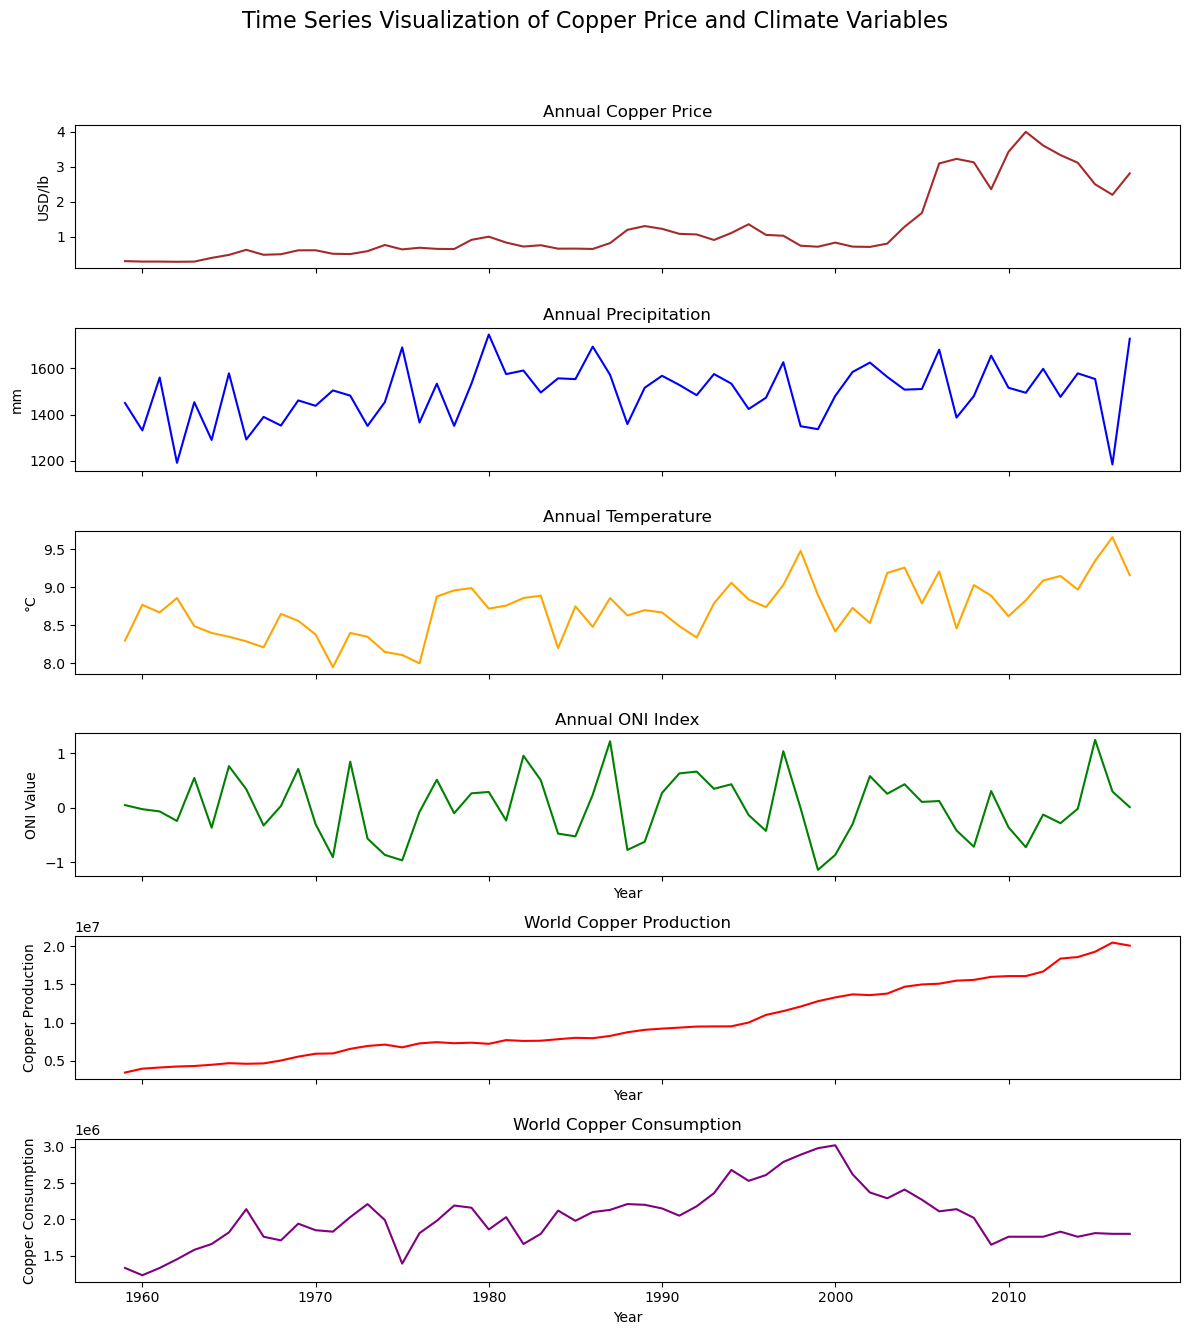

In [42]:
# Time Series Plots for Each Variable Separately
fig, axes = plt.subplots(6, 1, figsize=(12, 14), sharex=True)
fig.suptitle('Time Series Visualization of Copper Price and Climate Variables', fontsize=16)

# Copper Price
axes[0].plot(df_corrected_sorted['Year'], df_corrected_sorted['Copper_Price'], color='brown')
axes[0].set_title('Annual Copper Price')
axes[0].set_ylabel('USD/lb')

# Precipitation
axes[1].plot(df_corrected_sorted['Year'], df_corrected_sorted['Precipitation'], color='blue')
axes[1].set_title('Annual Precipitation')
axes[1].set_ylabel('mm')

# Temperature
axes[2].plot(df_corrected_sorted['Year'], df_corrected_sorted['Temperature'], color='orange')
axes[2].set_title('Annual Temperature')
axes[2].set_ylabel('°C')

# ONI Index
axes[3].plot(df_corrected_sorted['Year'], df_corrected_sorted['ONI'], color='green')
axes[3].set_title('Annual ONI Index')
axes[3].set_ylabel('ONI Value')
axes[3].set_xlabel('Year')

# World Copper Production
axes[4].plot(alldata['Year'], alldata['World production'], color='red')
axes[4].set_title('World Copper Production')
axes[4].set_ylabel('Copper Production')
axes[4].set_xlabel('Year')

# World Copper Demand
axes[5].plot(alldata['Year'], alldata['Consumption'], color='purple')
axes[5].set_title('World Copper Consumption')
axes[5].set_ylabel('Copper Consumption')
axes[5].set_xlabel('Year')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#
#corr_matrix = df_corrected_sorted[['Copper_Price', 'Precipitation', 'Temperature', 'ONI']].corr()

#plt.figure(figsize=(8, 6))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5, square=True)
#plt.title('Correlation Matrix: Copper Price vs Climate Variables')
#plt.tight_layout()
#plt.show()

#corr_matrix

# Part 3: Regression Analysis

## Correlation Matrix between All Variables

In [ ]:
corr_matrix2 = alldata[['Copper_Price', 'Precipitation', 'Temperature', 'ONI', 'Consumption', 'World production']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5, square=True)
plt.title('Correlation Matrix2: Copper Price vs All Variables')
plt.tight_layout()
plt.show()

corr_matrix2

## Regression1: Regress Copper Price only on climate variables

In [ ]:
# Step 7: Regression - all variables
X_all = df_corrected_sorted[['Precipitation', 'Temperature', 'ONI']]
X_all = sm.add_constant(X_all)
y_all = df_corrected_sorted['Copper_Price']
model_all = sm.OLS(y_all, X_all).fit()
print("\n--- Regression: Copper Price ~ Precip + Temp + ONI ---")
print(model_all.summary())

## Regression 2: Regress Copper Production on Climate Variables

In [ ]:
X_climate = alldata[['Precipitation', 'Temperature', 'ONI']]
X_climate = sm.add_constant(X_climate)
y_prod = alldata['World production']
model3 = sm.OLS(y_prod, X_climate).fit()
print("\n--- Regression: Copper Production ~ Precip + Temp + ONI---")
print(model3.summary())

## Regression 3: Regress Copper Demand on All Climate Variables

In [ ]:
y_demand = alldata['Consumption']
model4 = sm.OLS(y_demand, X_climate).fit()
print("\n--- Regression: Copper Demand ~ Precip + Temp + ONI---")
print(model4.summary())

## Regression 4: Regress Copper Price on All Variables (including Climate and Market)

In [ ]:
X_all2 = alldata[['Precipitation', 'Temperature', 'ONI', 'Consumption', 'World production']]
X_all2 = sm.add_constant(X_all2)
y_all2 = alldata['Copper_Price']
model_all2 = sm.OLS(y_all2, X_all2).fit()
print("\n--- Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production---")
print(model_all2.summary())

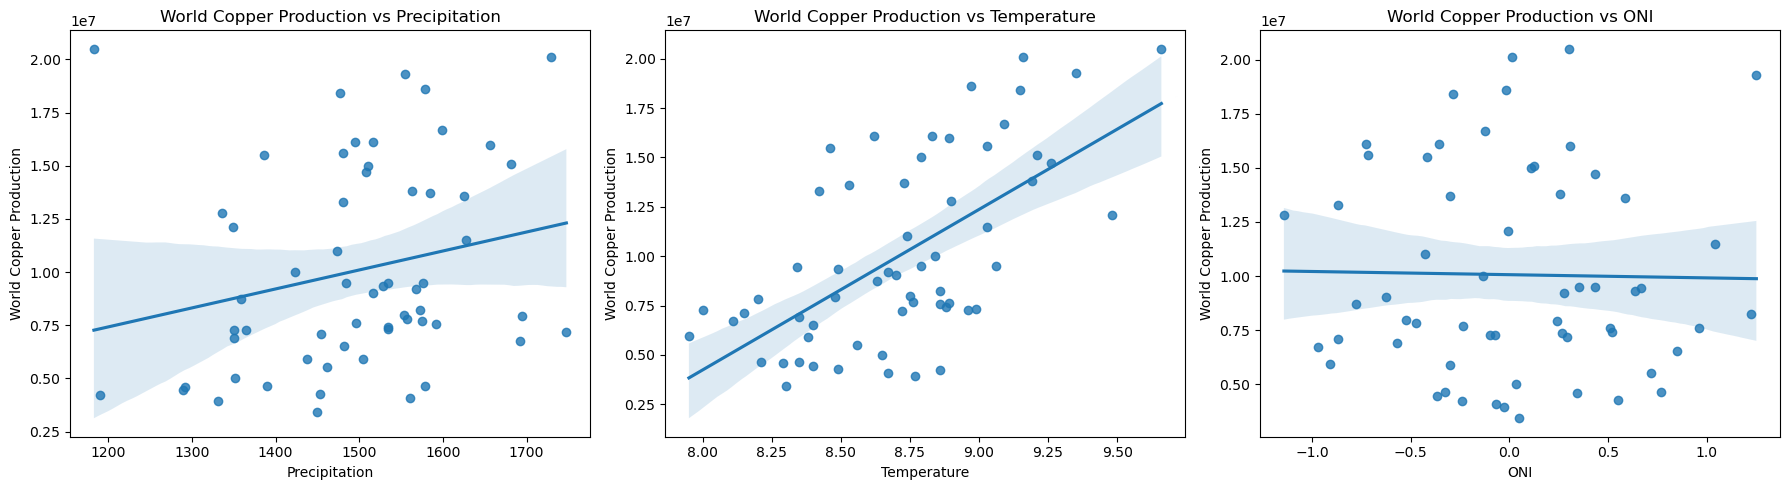

In [43]:
variables = ['Precipitation', 'Temperature', 'ONI']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, var in enumerate(variables):
    sns.regplot(x=var, y='World production', data=alldata, ax=axes[idx])
    axes[idx].set_title(f'World Copper Production vs {var}')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('World Copper Production')
plt.tight_layout()
plt.show()

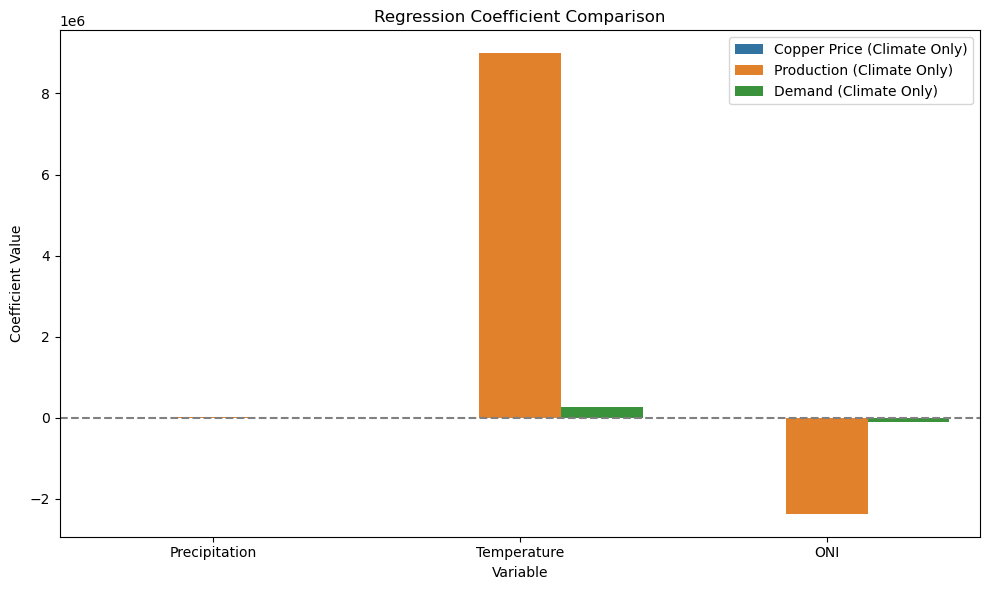

In [44]:
# Extracting coefficients from each model
coef_df = pd.DataFrame({
    'Variable': ['Precipitation', 'Temperature', 'ONI'],
    'Copper Price (Climate Only)': model_all.params[1:].values,
    'Production (Climate Only)': model3.params[1:].values,
    'Demand (Climate Only)': model4.params[1:].values,
})

coef_df_melted = coef_df.melt(id_vars='Variable', 
                              var_name='Regression Model', 
                              value_name='Coefficient')

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df_melted, x='Variable', y='Coefficient', hue='Regression Model')
plt.axhline(0, color='grey', linestyle='--')
plt.title('Regression Coefficient Comparison')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Simple Linear Regression: Copper Price v.s. Each Separate Variable

In [ ]:
# Regression - only temperature
X_temp = sm.add_constant(df_corrected_sorted[['Temperature']])
y_temp = df_corrected_sorted['Copper_Price']
model_temp = sm.OLS(y_temp, X_temp).fit()
print("\n--- Regression: Copper ~ Temp ONLY ---")
print(model_temp.summary())

In [ ]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df_corrected_sorted, x='Temperature', y='Copper_Price', ci=None, line_kws={'color': 'red'})
plt.title('Copper Price vs Annual Average Temperature (Chile)')
plt.xlabel('Annual Avg Temperature (°C)')
plt.ylabel('Annual Avg Copper Price (USD/lb)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Regression: Copper ~ Precipitation only
X_precip = sm.add_constant(df_corrected_sorted[['Precipitation']])
y_precip = df_corrected_sorted['Copper_Price']
model_precip = sm.OLS(y_precip, X_precip).fit()

In [ ]:
# Regression: Copper ~ ONI only
X_oni = sm.add_constant(df_corrected_sorted[['ONI']])
y_oni = df_corrected_sorted['Copper_Price']
model_oni = sm.OLS(y_oni, X_oni).fit()

In [ ]:
# Visualization - Copper vs Precipitation
plt.figure(figsize=(8, 5))
sns.regplot(data=df_corrected_sorted, x='Precipitation', y='Copper_Price', ci=None, line_kws={'color': 'red'})
plt.title('Copper Price vs Annual Precipitation (Chile)')
plt.xlabel('Annual Precipitation (mm)')
plt.ylabel('Annual Avg Copper Price (USD/lb)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Visualization - Copper vs ONI
plt.figure(figsize=(8, 5))
sns.regplot(data=df_corrected_sorted, x='ONI', y='Copper_Price', ci=None, line_kws={'color': 'red'})
plt.title('Copper Price vs ONI Index')
plt.xlabel('Annual ONI Index')
plt.ylabel('Annual Avg Copper Price (USD/lb)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model_precip.summary()

In [ ]:
model_oni.summary()